##### Author  : SIVA VIKNESH & YOUNES TATARI
##### Email   : siva.viknesh@sci.utah.edu / sivaviknesh14@gmail.com , younes.tatari@utah.edu/ younes.tatari@gmail.com
##### Address : SCI INSTITUTE, UNIVERSITY OF UTAH, SALT LAKE CITY, UTAH, USA

In [1]:
import os
import torch
import math
import numpy as np
import itertools
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as plticker
from mpl_toolkits.mplot3d import Axes3D
from scipy import integrate
rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]

from itertools import combinations
np.set_printoptions(threshold=np.inf)
np.set_printoptions(suppress=True, precision=15)

Two dimensional form of Van der pol oscillator:  <br>
Book: Understanding Nonlinear Dynamics By Daniel Kaplan, Leon Glass · 2012
$$
\begin{aligned}
\dot{x} & =  y\\
\dot{y} & = mu(1 - x^a)y -x \\
\end{aligned}
$$

Parameters: \\(mu\\) , \\(a\\)

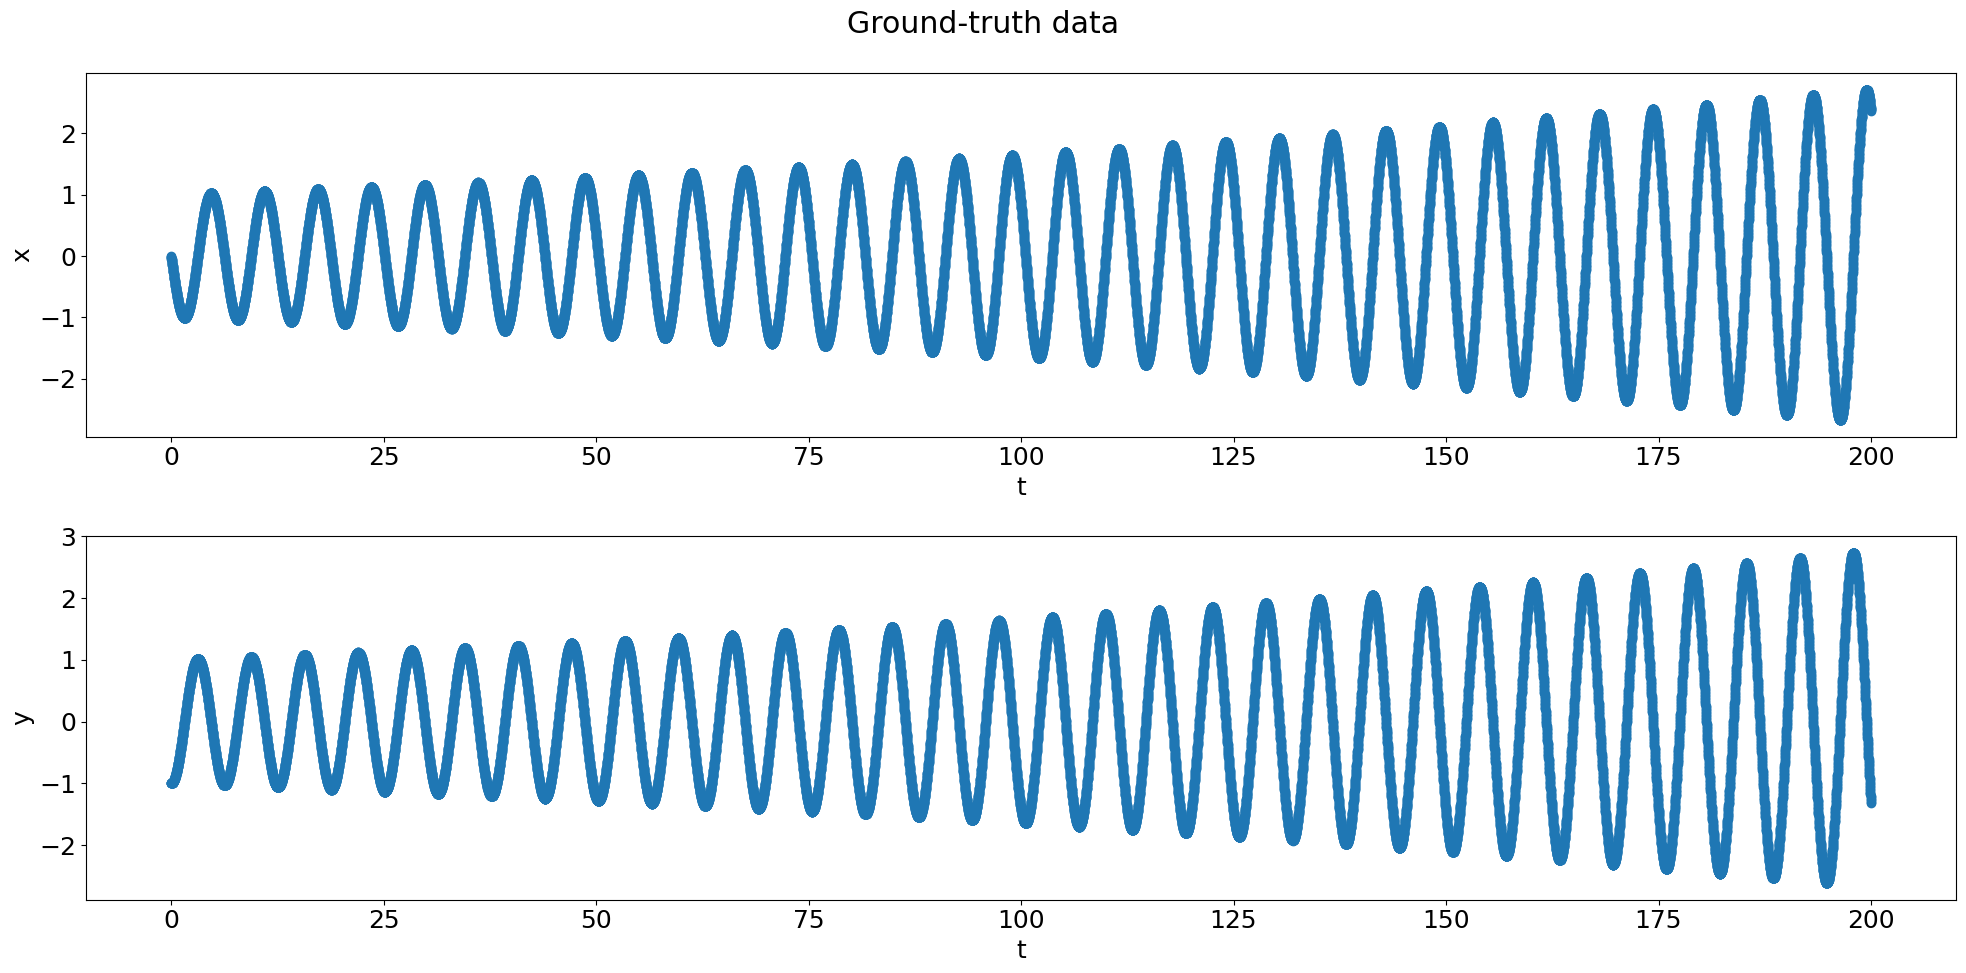

(20001, 2)


In [2]:
dt = 0.01
T  = 200
t  = np.arange(0,T+dt,dt)
mu = 0.01
a  = 2.15



def oscillator_deriv(x_y, t0, a = a, mu = mu):
    x, y = x_y
    x_powered = np.sign(x) * np.power(np.abs(x), a)
    dxdt = y
    dydt = mu * (1 - x_powered )*y - x
    return [dxdt, dydt]

np.random.seed(123)
x0 = (0, -1)
x_t = integrate.odeint(oscillator_deriv, x0, t, rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))
x, y = x_t.T

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize =(20, 10))
fig.suptitle('Ground-truth data')

ax[0].plot(t, x, '-o')
#ax[0].set_title('$x$')
ax[0].set(xlabel="t",ylabel="x")

ax[1].plot(t, y, '-o')
#ax[1].set_title('$y$')
ax[1].set(xlabel="t",ylabel="y")

fig.tight_layout()
plt.show()

print(x_t.shape)

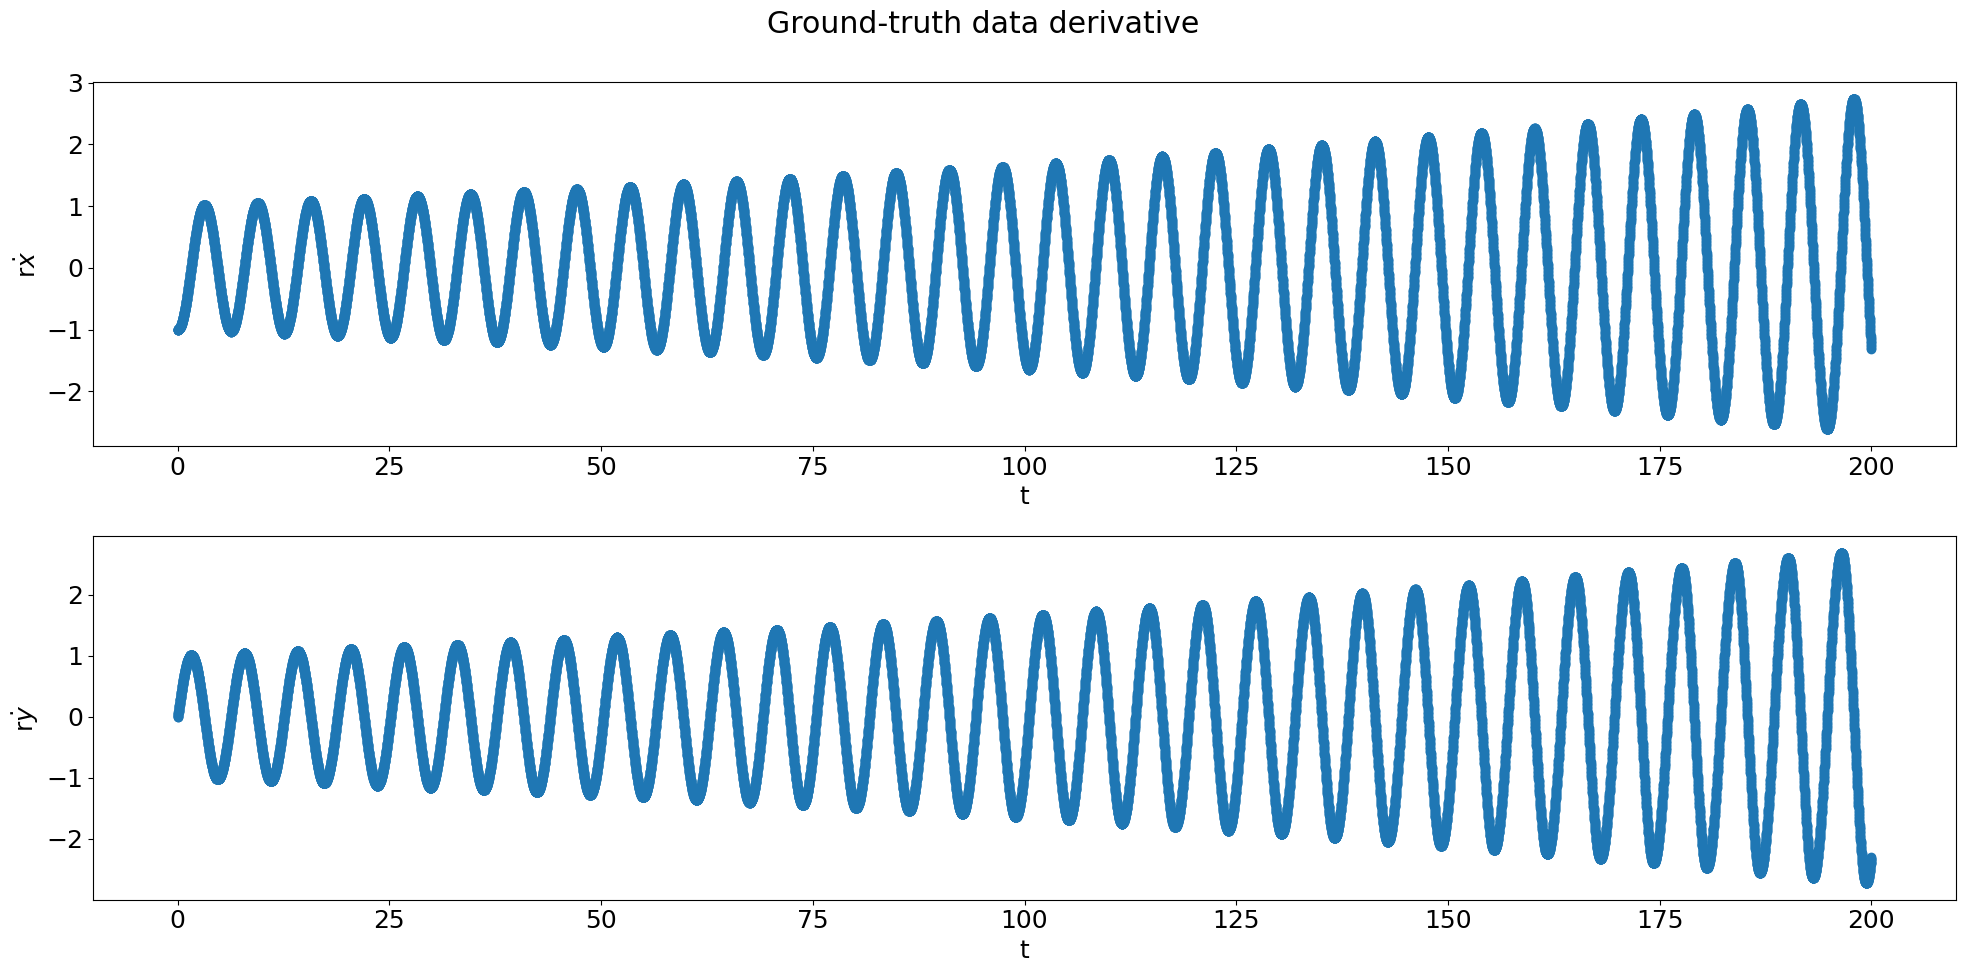

In [3]:
def DERIVATIVE(x, y, a, mu):
    x_powered = np.sign(x) * np.power(np.abs(x), a)
    dxdt = y
    dydt = mu * (1 - x_powered )*y - x
    return np.vstack((dxdt, dydt)).T

A1A2_time_deriv = DERIVATIVE (x, y, a, mu)

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize =(20, 10))
fig.suptitle('Ground-truth data derivative')

ax[0].plot(t, A1A2_time_deriv[:, 0], '-o')
ax[0].set(xlabel="t",ylabel="r$\dot{x}$")

ax[1].plot(t, A1A2_time_deriv[:, 1], '-o')
ax[1].set(xlabel="t",ylabel="r$\dot{y}$")

fig.tight_layout()
plt.show()

In [4]:
## SINDy Function Definitions
def poolData(yin,nVars,polyorder):
    n = yin.shape[0]
    yout = np.zeros((n,1))

    # poly order 0
    #yout[:,0] = np.ones(n)

    # poly order 1
    for i in range(nVars):
        yout = np.append(yout,yin[:,i].reshape((yin.shape[0],1)),axis=1)

    # poly order 2
    if polyorder >= 2:
        for i in range(nVars):
            for j in range(i,nVars):
                yout = np.append(yout,(yin[:,i]*yin[:,j]).reshape((yin.shape[0],1)),axis=1)

    # poly order 3
    if polyorder >= 3:
        for i in range(nVars):
            for j in range(i,nVars):
                for k in range(j,nVars):
                    yout = np.append(yout,(yin[:,i]*yin[:,j]*yin[:,k]).reshape((yin.shape[0],1)),axis=1)

    return yout

def sparsifyDynamics(Theta,dXdt,lamb,n): #Solves SINDy's L1 regularized convex optimization problem
    Xi = np.linalg.lstsq(Theta,dXdt,rcond=None)[0] # Initial guess: Least-squares

    for k in range(10):
        smallinds = np.abs(Xi) < lamb # Find small coefficients
        Xi[smallinds] = 0                          # and threshold
        for ind in range(n):                       # n is state dimension
            biginds = smallinds[:,ind] == 0
            # Regress dynamics onto remaining terms to find sparse Xi
            Xi[biginds,ind] = np.linalg.lstsq(Theta[:,biginds],dXdt[:,ind],rcond=None)[0]

    return Xi

In [5]:
# POLYNOMIAL TERMS
First_order_poly_candidate  = poolData(x_t, 2, 1)
First_order_poly_candidate = First_order_poly_candidate [:, 1:] # IGNORING THE CONSTANT - FIRST COLUMN !!!

# Define the powers
x_powers = [1, 2.15]
y_powers = [1, 2.15]

# Calculate x and y to their respective powers
x_powered = np.array([np.sign(x) * np.power(np.abs(x), p) for p in x_powers])
y_powered = np.array([np.sign(y) * np.power(np.abs(y), p) for p in y_powers])

combination = np.array([x_p * y_p for x_p, y_p in itertools.product(x_powered, y_powered)])
combination = combination.T

All_candidates  = np.hstack((First_order_poly_candidate, combination))

**Considering all the candidates in the optimization**

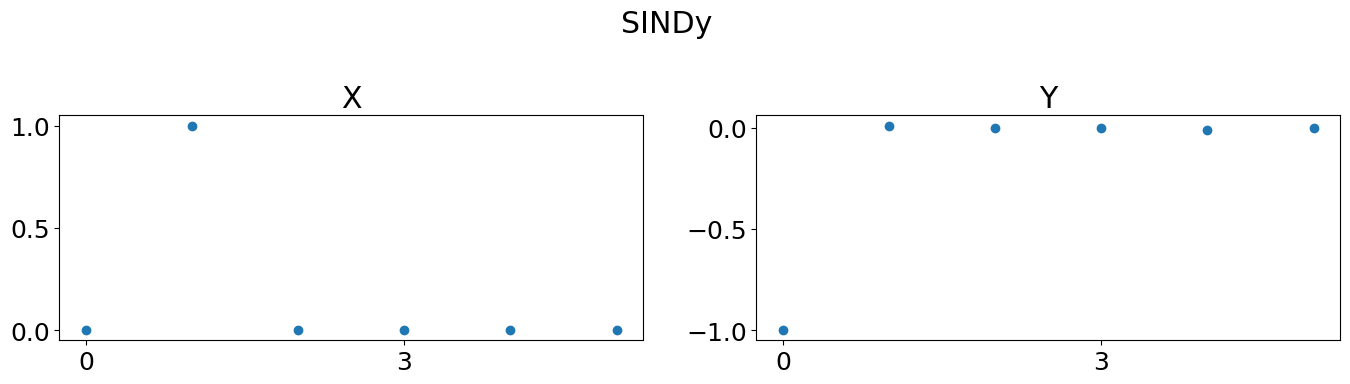

[0. 1. 0. 0. 0. 0.]
[-1.    0.01  0.    0.   -0.01  0.  ]


In [6]:
lamb = 0.0075 # sparsification knob lambda
coeff_matrix = sparsifyDynamics(All_candidates, A1A2_time_deriv, lamb, 2)
#print(coeff_matrix)
threshold = 0.00001
#****************************************************************************#
loc = plticker.MultipleLocator(base=3) # this locator puts ticks at regular intervals
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize =(14, 4))
fig.suptitle('SINDy')

ax[0].plot(coeff_matrix [:, 0], 'o')
ax[0].set_title('X')
ax[0].xaxis.set_major_locator(loc)

ax[1].plot(coeff_matrix [:, 1], 'o')
ax[1].set_title('Y')
ax[1].xaxis.set_major_locator(loc)

fig.subplots_adjust(top=0.8)
fig.tight_layout()
plt.show()

print(coeff_matrix[:, 0])
print(coeff_matrix[:, 1])